In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing

In [2]:
####################### DATA Manipulation #######################
#transactionsDataset = pd.read_csv('/Users/miguel/Documents/Fundler/data/transactions_contacts.csv')
transactionsDataset = pd.read_excel("/Users/migueltorresporta/Documents/medium/OnlineRetail.xlsx")

## Exploratory Data Analysis (EDA)

It is a tubular transactional data set that contains the transactions from an UK-based retail store. 
Most of the customers are wholesalers.

http://archive.ics.uci.edu/ml/datasets/Online+Retail

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 

- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 

- Description: Product (item) name. Nominal. 

- Quantity: The quantities of each product (item) per transaction. Numeric.	

- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 

- UnitPrice: Unit price. Numeric, Product price per unit in sterling. 

- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 

- Country: Country name. Nominal, the name of the country where each customer resides.

In [3]:
transactionsDataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print(transactionsDataset['InvoiceDate'].min()) # min 2010-12-01
print(transactionsDataset['InvoiceDate'].max()) # max 2011-12-09

2010-12-01 08:26:00
2011-12-09 12:50:00


## Data preprocessing

Remove all cancelations....

In [5]:
mask = transactionsDataset[transactionsDataset['Quantity']<0].index
transactionsDataset = transactionsDataset.drop(mask)
transactionsDataset = transactionsDataset.dropna(subset=['CustomerID'])

Calculate the total price per invoice 

In [6]:
transactionsDataset['PriceInvoice'] = transactionsDataset['Quantity'] * transactionsDataset['UnitPrice']

Remove the unnecessary columns...

In [7]:
transactionsDataset = transactionsDataset.drop(['StockCode','Quantity','UnitPrice','Description','Country'], axis = 1)

In [8]:
transactionsDataset.head()

,InvoiceNo,InvoiceDate,CustomerID,PriceInvoice
0,536365,2010-12-01 08:26:00,17850.0,15.30
1,536365,2010-12-01 08:26:00,17850.0,20.34
2,536365,2010-12-01 08:26:00,17850.0,22.00
3,536365,2010-12-01 08:26:00,17850.0,20.34
4,536365,2010-12-01 08:26:00,17850.0,20.34


Grouping by invoice

In [9]:
f = {'PriceInvoice':'sum',
    'CustomerID':'first',
     'InvoiceDate':'first'
    }
tx = transactionsDataset.groupby('InvoiceNo').agg(f)
tx.head()

,PriceInvoice,CustomerID,InvoiceDate
InvoiceNo,,,
536365,139.12,17850.0,2010-12-01 08:26:00
536366,22.20,17850.0,2010-12-01 08:28:00
536367,278.73,13047.0,2010-12-01 08:34:00
536368,70.05,13047.0,2010-12-01 08:34:00
536369,17.85,13047.0,2010-12-01 08:35:00


In [10]:
# set date as index
tx['InvoiceDate'] = pd.DatetimeIndex(tx['InvoiceDate'])
tx = tx.set_index('InvoiceDate')

In [11]:
tx.shape

(18536, 2)

In [12]:
tx['CustomerID'].nunique()

4339

In [13]:
tx.head()

,PriceInvoice,CustomerID
InvoiceDate,,
2010-12-01 08:26:00,139.12,17850.0
2010-12-01 08:28:00,22.20,17850.0
2010-12-01 08:34:00,278.73,13047.0
2010-12-01 08:34:00,70.05,13047.0
2010-12-01 08:35:00,17.85,13047.0


Grouping the invoices by month and customer

In [14]:
f = {'PriceInvoice':['sum','count']}
tx = tx.groupby('CustomerID').resample('m').agg(f)

In [15]:
tx = tx.reset_index()
#tx = tx.drop('InvoiceDate', axis = 1)

In [16]:
tx.columns = tx.columns.map(''.join)
tx = tx.rename(columns = {'PriceInvoicesum':'PriceInvoices', 'PriceInvoicecount':'TotalInvoices'})

Deleting the outliers (Clients more than 15 transctions per month and more than 20000£ spendings)


In [17]:
tx = tx.drop(tx[tx['PriceInvoices']> 20000].index)
tx = tx.drop(tx[tx['TotalInvoices']> 15].index)

In [18]:
### ALL GOOD TO HERE

### Train

In [19]:
baseline = tx[(tx['InvoiceDate'] < '2011-08-01')].copy(deep = True)
baseline = baseline.drop('InvoiceDate', axis = 1)

In [20]:
baseline.head()

,CustomerID,PriceInvoices,TotalInvoices
1,12347.0,711.79,1
2,12347.0,475.39,1
3,12347.0,0.00,0
4,12347.0,0.00,0
5,12347.0,636.25,1


In [21]:
baseline = baseline.groupby('CustomerID').mean()

In [22]:
baseline.head()

,PriceInvoices,TotalInvoices
CustomerID,,
12347.0,275.743750,0.500000
12348.0,185.905000,0.375000
12350.0,334.400000,1.000000
12352.0,260.301667,0.833333
12353.0,89.000000,1.000000


### Test

In [23]:
testset =  tx[~(tx['InvoiceDate'] < '2011-08-01')].copy(deep = True)
testset = testset.drop('InvoiceDate', axis = 1)

In [24]:
testset.head()

,CustomerID,PriceInvoices,TotalInvoices
9,12347.0,584.91,1
10,12347.0,0.00,0
11,12347.0,1294.32,1
12,12347.0,0.00,0
13,12347.0,224.82,1


In [25]:
testset = testset.groupby('CustomerID').mean()

In [26]:
testset.head()

,PriceInvoices,TotalInvoices
CustomerID,,
12347.0,420.8100,0.60
12348.0,155.0000,0.50
12349.0,1757.5500,1.00
12352.0,236.0575,0.75
12356.0,14.5875,0.25


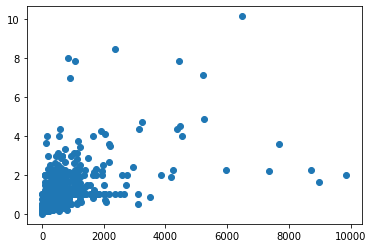

In [27]:
plt.scatter(baseline['PriceInvoices'], baseline['TotalInvoices'])

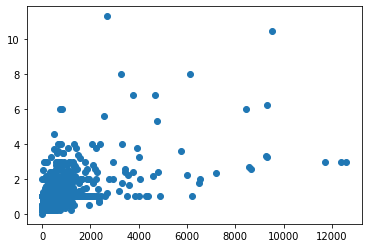

In [28]:
plt.scatter(testset['PriceInvoices'], testset ['TotalInvoices'])

## K-Means

In [29]:
baseline.head()

,PriceInvoices,TotalInvoices
CustomerID,,
12347.0,275.743750,0.500000
12348.0,185.905000,0.375000
12350.0,334.400000,1.000000
12352.0,260.301667,0.833333
12353.0,89.000000,1.000000


In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
baseline_norm = pd.DataFrame(scaler.fit_transform(baseline), 
                             index = baseline.index, columns = ['PriceInvoices','TotalInvoices'])

In [31]:
baseline_norm

,PriceInvoices,TotalInvoices
CustomerID,,
12347.0,0.027954,0.049180
12348.0,0.018846,0.036885
12350.0,0.033900,0.098361
12352.0,0.026388,0.081967
12353.0,0.009022,0.098361
...,...,...
18273.0,0.001034,0.019672
18280.0,0.018309,0.098361
18281.0,0.008193,0.098361


In [32]:

# Fitting K-Means to the dataset
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 1, verbose = 0)
y_kmeans_train = kmeans.fit_predict(baseline_norm)


In [33]:
y_kmeans_train

array([1, 1, 0, ..., 0, 0, 1], dtype=int32)

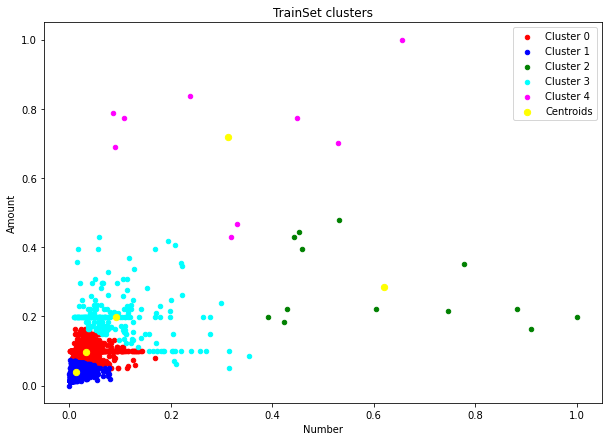

In [34]:
X_train = baseline_norm.values
# Visualising the clusters

# Visualising the clusters
plt.figure(figsize=(10,7))
plt.scatter(X_train[y_kmeans_train == 0, 0], X_train[y_kmeans_train == 0, 1], s = 20, c = 'red', label = 'Cluster 0')
plt.scatter(X_train[y_kmeans_train == 1, 0], X_train[y_kmeans_train == 1, 1], s = 20, c = 'blue', label = 'Cluster 1')
plt.scatter(X_train[y_kmeans_train == 2, 0], X_train[y_kmeans_train == 2, 1], s = 20, c = 'green', label = 'Cluster 2')
plt.scatter(X_train[y_kmeans_train == 3, 0], X_train[y_kmeans_train == 3, 1], s = 20, c = 'cyan', label = 'Cluster 3')
plt.scatter(X_train[y_kmeans_train == 4, 0], X_train[y_kmeans_train == 4, 1], s = 20, c = 'magenta', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 40, c = 'yellow', label = 'Centroids')
plt.title("TrainSet clusters")
plt.ylabel("Amount")
plt.xlabel("Number")
plt.legend()
plt.show()

In [35]:
results_train = pd.DataFrame(y_kmeans_train, index=baseline.index, columns = ['cluster'])

In [36]:
results_train

,cluster
CustomerID,
12347.0,1
12348.0,1
12350.0,0
12352.0,0
12353.0,0
...,...
18273.0,1
18280.0,0
18281.0,0


### K-Means

#### Test set

Put the test set as the scale as the baseline. 

Even thought the rusult might be similar if we scale the whole dataset at the same time, the first ... ... 
The reason to adapting the scale and not scaling the whole dataset at the same time is that failing to do so ... ... 

In [37]:
testdf = pd.DataFrame(scaler.transform(testset), index = testset.index, columns = ['PriceInvoices','TotalInvoices'])

Get the claster for the data points belong to

In [38]:
y_kmeans_test = kmeans.predict(testdf.values)

Plotting the results

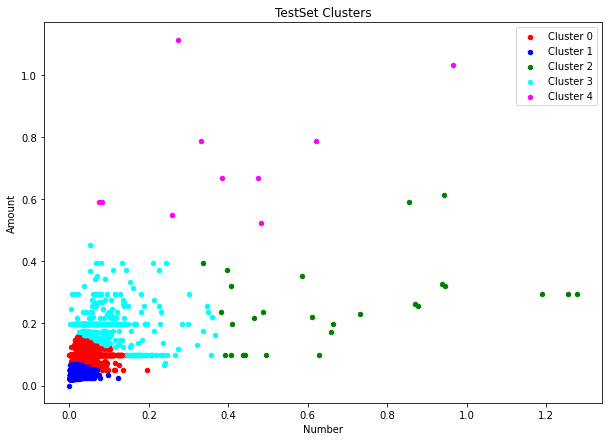

In [39]:

X_test = testdf.values
# Visualising the clusters
plt.figure(figsize=(10,7))
plt.scatter(X_test[y_kmeans_test == 0, 0], X_test[y_kmeans_test == 0, 1], s = 20, c = 'red', label = 'Cluster 0')
plt.scatter(X_test[y_kmeans_test == 1, 0], X_test[y_kmeans_test == 1, 1], s = 20, c = 'blue', label = 'Cluster 1')
plt.scatter(X_test[y_kmeans_test == 2, 0], X_test[y_kmeans_test == 2, 1], s = 20, c = 'green', label = 'Cluster 2')
plt.scatter(X_test[y_kmeans_test == 3, 0], X_test[y_kmeans_test == 3, 1], s = 20, c = 'cyan', label = 'Cluster 3')
plt.scatter(X_test[y_kmeans_test == 4, 0], X_test[y_kmeans_test == 4, 1], s = 20, c = 'magenta', label = 'Cluster 4')
plt.legend()
#plt.xlim(-0.1,1.3)
#plt.ylim(-0.1,1)
plt.title("TestSet Clusters")
plt.ylabel("Amount")
plt.xlabel("Number")
plt.show()


Joining clients id with their new dataset, merging it with their previous state and finding the one that move to a different cluster

In [40]:

results_test = pd.DataFrame(y_kmeans_test, index=testdf.index, columns = ['cluster'])
results_merged = pd.merge(results_train, results_test, left_index=True, right_index=True, how='inner')
diff = results_merged.iloc[np.where(results_merged['cluster_x'] != results_merged['cluster_y'])[0],:]

In [41]:
diff.shape

(785, 2)

There are 785 client who changed the cluster. As these are still many, I´ll get only the ones with the biggest changes

In [42]:
import math  

### Calculate de distance between the flagged clients
def calculateDistance(x1,y1,x2,y2):  
     dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist  

In [43]:
df_coord = pd.DataFrame()

df_coord['x_before'] = info_train.iloc[:,0]
df_coord['y_before'] = info_train.iloc[:,1]
df_coord['x_after'] = info_test.iloc[:,0]
df_coord['y_after'] = info_test.iloc[:,1]
df_coord['distance'] = calculateDistance(df_coord['x_before'],df_coord['y_before'],df_coord['x_after'],df_coord['y_after'])

plt.hist(df_coord['distance'])

NameError: name 'info_train' is not defined

Getting only the clients with distance higher 0.05

In [ ]:
diff = df_coord.iloc[np.where(df_coord['distance'] > 0.25)]

Getting their possitions for the identified ones

In [ ]:
first_period = baseline_norm.loc[diff.index,:]
second_period = testdf.loc[diff.index,:]

In [ ]:

## Get only the clients with distance higher 0.05
diff = df_coord.iloc[np.where(df_coord['distance'] > 0.25)]

plt.figure(figsize=(10,7))
plt.scatter(X_test[y_kmeans_test == 0, 0], X_test[y_kmeans_test == 0, 1], s = 20, c = 'red', label = 'Cluster 0')
plt.scatter(X_test[y_kmeans_test == 1, 0], X_test[y_kmeans_test == 1, 1], s = 20, c = 'blue', label = 'Cluster 1')
plt.scatter(X_test[y_kmeans_test == 2, 0], X_test[y_kmeans_test == 2, 1], s = 20, c = 'green', label = 'Cluster 2')
plt.scatter(X_test[y_kmeans_test == 3, 0], X_test[y_kmeans_test == 3, 1], s = 20, c = 'cyan', label = 'Cluster 3')
plt.scatter(X_test[y_kmeans_test == 4, 0], X_test[y_kmeans_test == 4, 1], s = 20, c = 'magenta', label = 'Cluster 4')
#plt.plot([info_train.iloc[0,0],info_test.iloc[0,0]], [info_train.iloc[0,1],info_test.iloc[0,1]], 'ro-' )
for i in range(0, len(diff)):
    plt.plot([diff.iloc[i,0],diff.iloc[i,2]], [diff.iloc[i,1],diff.iloc[i,3]], 'yo-' )
plt.legend()
plt.title("Clients with higher distances ")

plt.ylabel("Amount")
plt.xlabel("Number")
plt.show()
